# House Price Prediction (2):

## Goals:

1. Build a model to predict the `house price` using features like `ocean_proximity`, `total_rooms`, `longitude`, `latitude`.

## **Highlight**
1. Prepare Data (Data Wrangling)

    1. `Import`: wrangle `function`
    2. Explore/ Assess data: `Null values, high and low cardinality (number of unique observations in the variables), leakage, multicollinearity`.
    3. Split 
---
2. Build Model
    1. Baseline
    2. Iterate
    3. Evaluate
    4. Deployment
---
3. Communicate Results
    1. make_prediction `function`
    2. Interactive dashboard `MVP (Minimum Viable Product)`


In [1]:
# Import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
import pickle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegressionCV
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact # Interactive Dashboard


warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


### Import and wrangle data

In this section, the dataset is imported and wrangled for further analysis.

In [2]:
# Load dataset
df = pd.read_csv('housing.csv')
# Inpect dataset
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Investigate dataset
print(f"Shape of dataset: {df.shape}")
df.info()

Shape of dataset: (20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Checking for missing values in total_bedrooms
df['total_bedrooms'].isna().sum()

207

In [5]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# Encoding the observations of ocean_proximity
df['ocean_proximity'] = (df['ocean_proximity']
                         .map({'<1H OCEAN':'1',
                               'INLAND':'2',
                               'NEAR OCEAN':'3',
                               'NEAR BAY':'4',
                               'ISLAND':'5'})
                         )

# Inspecting the column
df['ocean_proximity'].value_counts()

1    9136
2    6551
3    2658
4    2290
5       5
Name: ocean_proximity, dtype: int64

**Exploratory Data Analysis**



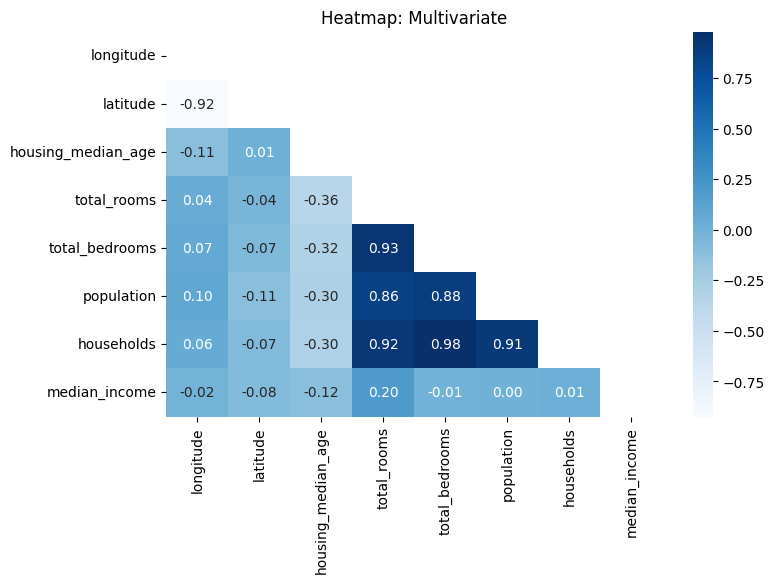

In [7]:
# Multivariate exploratory analysis
# Using heatmap to detect multicollinearity in the dataset. Drop median_house_value, it's the target vector
corr = df.drop(columns='median_house_value', axis=1).corr()
plt.figure(figsize=[8,5])
mask = np.triu(np.ones_like(corr, dtype= bool))
sns.heatmap(data=corr, annot=True, fmt=".2f", cmap='Blues', mask=mask)
plt.title('Heatmap: Multivariate');

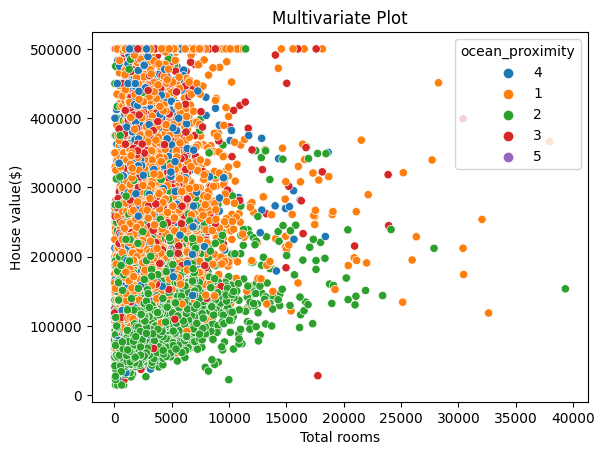

In [8]:
# Plot of multivariate
sns.scatterplot(data=df, x='total_rooms', y='median_house_value', hue='ocean_proximity')
plt.title('Multivariate Plot')
plt.xlabel('Total rooms')
plt.ylabel('House value($)');

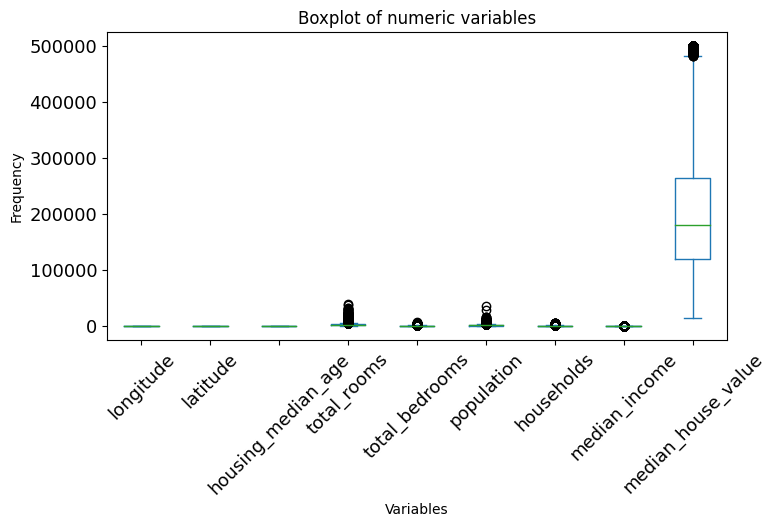

In [9]:
df.select_dtypes(include='number').plot(kind='box', figsize=[8,4], title='Boxplot of numeric variables',
                                        xlabel='Variables',ylabel='Frequency',legend=True,fontsize=13,
                                        )
plt.xticks(rotation=45);

**Creating Alternative Function**

In [10]:
# Create a wrangle function
def wrangle2(filepath):
    data = pd.read_csv(filepath)

    # Make copy of dataset
    df = data.copy()

    # Subset data: Remove outliers from total rooms
    low, high = df['total_rooms'].quantile([0.1, 0.9])
    mask_total_rooms = df['total_rooms'].between(low,high)
    df = df[mask_total_rooms]

    # Subset data: Drop columns with multicollinearity
    df.drop(columns=['total_bedrooms','population','households'], axis=1, inplace=True)

    # Subset data: Drop other irrelevant columns
    df.drop(columns=['housing_median_age','median_income'], axis=1, inplace=True)

    # Encoding the observations of ocean_proximity
    ocean_proximity = {'<1H OCEAN':'1',
                                'INLAND':'2',
                                'NEAR OCEAN':'3',
                                'NEAR BAY':'4',
                                'ISLAND':'5'}
    df['ocean_proximity'] = (df['ocean_proximity']
                            .map(ocean_proximity)
                            )
    
    # Re-ordering the index number
    index = range(0,len(df))
    df.index = index
    
    return df


**Re-assessing cleaned dataset**

In [11]:
# Re-assess dataset with wrangle function
df2 = wrangle2('housing.csv')
# Select random sample
print(f"Summary of dataset: {df.info()}")
df2.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
Summary of dataset: None


,longitude,latitude,total_rooms,median_house_value,ocean_proximity
11460,-118.34,34.15,1586.0,450000.0,1
9417,-122.02,38.02,1465.0,156900.0,4
9573,-118.34,34.08,1421.0,500001.0,1
14749,-118.38,33.91,2904.0,289600.0,1
6682,-117.96,33.80,1493.0,218000.0,1
3281,-122.34,37.57,3751.0,300000.0,3
7250,-117.08,32.63,2891.0,139800.0,3
3615,-117.89,34.01,4535.0,154100.0,1
4271,-118.13,33.76,2532.0,406900.0,3
7482,-118.27,33.89,1969.0,138100.0,1


**Alternative wrangle function**

### Split Data

In [12]:
# Target vector
y = df2['median_house_value']

# Feature matrix
X = df2.drop(columns='median_house_value')

# Check variables
print(f"Shape of target vector: {y.shape}")
print(f"Shape of feature matrix: {X.shape}")

Shape of target vector: (16516,)
Shape of feature matrix: (16516, 4)


In [13]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (13212, 4)
y_train shape: (13212,)
X_test shape: (3304, 4)
y_test shape: (3304,)


## Build Model

### Baseline Model

In [14]:
y_train_median = np.median(sorted(y_train))
y_baseline_pred = [y_train_median]*len(y_train)
print(f"Median House Value: {y_train_median}")
print(f"Baseline MAE: {round(mean_absolute_error(y_train, y_baseline_pred),5)}")
print(f"Baseline R^2: {round(r2_score(y_train, y_baseline_pred),5)}")
print(f"Baseline MAPE: {round(mean_absolute_percentage_error(y_train, y_baseline_pred),5)}")

Median House Value: 181300.0
Baseline MAE: 87212.35793
Baseline R^2: -0.05111
Baseline MAPE: 0.51838


### Iterate Model

In [15]:
# Instantiate model
model = make_pipeline(
    Normalizer(),
    RidgeCV(alphas=(0.1,1,10), cv=5)
)

model

Pipeline(steps=[('normalizer', Normalizer()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5))])

In [16]:
# Check model
assert isinstance(model, Pipeline)

In [17]:
# Fit model
model.fit(X_train, y_train)

# Check fitted model
check_is_fitted(model[1])

In [18]:
# Predict the median house value with the training set
y_train_pred  = model.predict(X_train)

In [19]:
# Check accuracy of the model
print(f"Train MAE: {round(mean_absolute_error(y_train, y_train_pred),5)}")
print(f"Train MAPE: {round(mean_absolute_percentage_error(y_train, y_train_pred),5)}")
# print(f"Train accuracy score: {round(model.score(X_train, y_train),2)}")

Train MAE: 87986.95716
Train MAPE: 0.58789


### Evaluate Model

In [20]:
# Predicting test target vector
y_test_pred = pd.DataFrame(model.predict(X_test))

In [21]:
# Evaluating model
print(f"Test MAE: {round(mean_absolute_error(y_test, y_test_pred),5)}")
print(f"Test MAPE: {round(mean_absolute_percentage_error(y_test, y_test_pred),5)}")

Test MAE: 92375.96558
Test MAPE: 0.61932


### Communicate Result

Create a function that takes the `feature matrix` as input and returns the `predicted house price`. 

In [22]:
# Create prediction function
# def make_prediction(longitude, latitude, total_rooms, ocean_proximity):
    
def make_prediction(
        longitude: pd.Series, latitude: pd.Series, total_rooms: pd.Series, ocean_proximity: pd.Series
        )-> pd.Series:
    """To return Series target variable

    Params:
        longitude (int): Returns longitude
        latitude (int): Returns latitude
        total_rooms (int): Returns the total rooms
        ocean_proximity (str): Returns the ocean proximity

    Returns:
        output (pd.Series): Returns predicted house price
    """
    data = {
        'longitude': longitude,
        'latitude': latitude,
        'total_rooms': total_rooms,
        'ocean_proximity': ocean_proximity
    }
    df = pd.DataFrame(data=data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted house value: ${prediction}"

**Alternative Prediction Function**

In [23]:
# Create prediction function
# def make_prediction(longitude, latitude, total_rooms, ocean_proximity):
    
def make_pred_2(
        longitude: pd.Series, latitude: pd.Series, total_rooms: pd.Series, ocean_proximity: pd.Series
        )-> pd.Series:
    """To return Series target variable

    Params:
        longitude (int): Returns longitude
        latitude (int): Returns latitude
        total_rooms (int): Returns the total rooms
        ocean_proximity (str): Returns the ocean proximity

    Returns:
        output (pd.Series): Returns predicted house price
    """
    longitude = int(input("Enter longitude between [-124.35,-114.49]"))
    latitude = int(input("Enter latitude between [32.55, 41.95]"))
    try:
        total_rooms = int(input("Enter No of rooms between 941 and 4651:"))
    except:
        print('Invalid input! Enter integer values')
    try:
        ocean_proximity =input("Enter location name: Values between 1 and 5")
    except:
        print('Enter integer between 1 and 5')
        pass
    data = {
        'longitude': longitude,
        'latitude': latitude,
        'total_rooms': total_rooms,
        'ocean_proximity': ocean_proximity
    }
    df = pd.DataFrame(data=data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted house value: ${prediction}"

In [ ]:
# Make prediction
# Prompt input using input
make_pred_2(longitude=-120, latitude=35, total_rooms=1000, ocean_proximity=3)

In [25]:
# Make prediction
make_prediction(longitude=-120.02, latitude=35, total_rooms=1085, ocean_proximity=3)

'Predicted house value: $172318.7'

In [26]:
# Create an interact function in Jupyter Widgets.

interact(
    make_prediction,
    longitude=FloatSlider(
        min=X_train["longitude"].min(),
        max=X_train["longitude"].max(),
        step = 0.01,
        value=X_train["longitude"].mean(),
    ),
    latitude=FloatSlider(
        min=X_train["latitude"].min(),
        max=X_train["latitude"].max(),
        step = 0.01,
        value=X_train["latitude"].mean(),
    ),
    total_rooms=IntSlider(
        min=X_train["total_rooms"].min(),
        max=X_train["total_rooms"].max(),
        value=X_train["total_rooms"].mean(),
    ),
    ocean_proximity=Dropdown(
    options=sorted(X_train['ocean_proximity'].unique())
    )
);


interactive(children=(FloatSlider(value=-119.58441871026339, description='longitude', max=-114.49, min=-124.35…

In [27]:
# Obtain the intercept and coeff. of the model
intercept = model.named_steps['ridgecv'].intercept_.round(2)
coeff = model.named_steps['ridgecv'].coef_.round(2)
print(f"intercept: {intercept}")
print(f"coeff: {coeff[:3]}")


intercept: 353994.61
coeff: [   77569.65 -2270361.85  -101766.3 ]


#### Save Model

In [107]:
# Save the model
with open('lr_model_2', 'wb') as f:
    pickle.dump(model, f)